In [2]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import bicgstab
from scipy import sparse
import Reader as rd
from glob import glob
import matplotlib.patches as patches
import pandas as pd
import math
from scipy.misc import imread
#import bcolz
import time
import os

In [3]:
def makeChessBoard(WhiteFrameWidth, chessNodeWidth, chessElementNumberPerRow):
    size = WhiteFrameWidth * 2 + chessElementNumberPerRow * chessNodeWidth
    A = np.zeros((size, size))
    for i in range(size - 2 * WhiteFrameWidth):
        for j in range(size - 2 * WhiteFrameWidth):
            if ((int(i / chessNodeWidth)) + (int(j / chessNodeWidth))) % 2 == 0:
                A[WhiteFrameWidth + i][WhiteFrameWidth + j] = 200
    return A

In [4]:
def e_neighbour_graph(img, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            result[row * colN + col][(row + rowDiff) * colN + (col + colDiff)] = 1
    return result


def fully_connected_graph(img, sigma):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for row2 in range(rowN):
                for col2 in range(colN):
                    weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                    result[row * colN + col][row2 * colN + col2] = weight
    return result


def fully_connected_e_neighbour_graph(img, sigma, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    # Avoid self edges
                    if rowDiff == 0 and colDiff == 0:
                        continue
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            row2 = row + rowDiff
                            col2 = col + colDiff
                            weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                            result[row * colN + col][row2 * colN + col2] = weight
    # Convert it to sparse matrix
    # TODO: Direct initialization as sparse matrix is better
    return sparse.csr_matrix(result)

def laplacian(graph):
    # diag = np.diag(sum(graph))
    diag = sparse.diags((sum(graph)).toarray()[0], 0)
    lap = diag - graph
    return [lap, diag]


def orthogonalize(diag, s):
    nodeNum = diag.shape[0]
    # p = np.ones((nodeNum, 1)) / pow(sum(np.diag(np.diag(sum(diag)))), .5)
    p = np.ones((nodeNum, 1)) / pow(sum(diag.diagonal()), .5)
    # projection = np.dot(np.transpose(s), np.dot(diag, p))
    projection = np.dot(np.transpose(s), diag.dot(p))
    v = s - projection[0][0] * p
    # return [v, projection]
    return v


def PRwalk(graph, alpha, s):
    if alpha < 0:
        print('Error: alpha must be positive!')
        return -1
    # nodeNum = len(graph)
    nodeNum = graph.shape[0]
    [L, D] = laplacian(graph)
    s = orthogonalize(D, s)
    # v, flag = bicgstab((L + alpha * D), np.dot(D, s),tol=1e-3, maxiter=nodeNum)

    # v, flag = bicgstab((L + alpha * D).toarray(), D.dot(s),tol=1e-3, maxiter=nodeNum)
    v, flag = bicgstab((L + alpha * D), D.dot(s),tol=1e-3, maxiter=nodeNum)
    
    
    v = np.reshape(v, (len(v), 1))

    v = orthogonalize(D, v)
    return v

def PRobjective(graph, seed, myImg, e):
    
    [L, D] = laplacian(graph)
    s = orthogonalize(D, seed)
    s = normalize(D, s)
    # print('Threshold: ' + str(1 / len(graph)))
    print('Threshold: ' + str(1 / graph.shape[0]))
    alphaList = []    
    correlationList = []
    scoreList = []
    valueList = []
    minCondList = []
    minCondIndexList = []
    
    exponential = -14
    # correlation = 1 / len(graph) + 1 # to get into loop
    correlation = 1 / graph.shape[0] + 1 # to get into loop
    
    MAXITER = 16
    # MINITER = 4
    for i in range(MAXITER):
        # if correlation > 1 / len(graph):
        oldCorrelation = correlation
        exponential -= 1
        alpha = 2 ** exponential
        v = PRwalk(graph, alpha, s)
        # normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
        normalization = (np.dot(np.transpose(D.dot(v)), v))[0][0]
        
        # correlation = \
        #     (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
        correlation = \
        pow(np.dot(np.transpose(D.dot(v)), s)[0][0], 2) / normalization        
        
        # score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]
        score = (np.dot(np.transpose(L.dot(v)), v) / normalization)[0][0]
        
        print('--')
        print('alpha: 2^' + str(exponential))
        print('Correlation: ' + str(correlation))
        print('Score: ' + str(score))
        
        [minCond, minCondIndex] = sweepCut(v, D, e, myImg)
        
        print('Heatmap:\n')
        heat = np.zeros(myImg.shape)
        for ii in range(myImg.shape[0]):
            for jj in range(myImg.shape[1]):
                heat[ii][jj] = v[ii * myImg.shape[1] + jj]    
        plt.imshow(heat, cmap='hot', interpolation='nearest')
        plt.show()
        
        # if i == MINITER:
        #    print('**')
        #    print('Starting correlation decrease check!')

        # if i >= MINITER and oldCorrelation * .99 < correlation:
        #    break

        alphaList.append(alpha)
        correlationList.append(correlation)
        scoreList.append(score)
        valueList.append(v)
        minCondList.append(minCond)
        minCondIndexList.append(minCondIndex)
            
    print('****')
    plt.plot(correlationList, scoreList, 'r*--')
    plt.xlabel('Correlation')
    plt.ylabel('Score')
    plt.show()
    
    return [alphaList, correlationList, scoreList, valueList, minCondList, minCondIndexList]


def sweepCut(v, D, e, myImg):
    
    sortedArgsValues = np.argsort(v[:,0])[::-1]

    # row: int(np.argsort(value[:,0])[::-1][0] / myImg.shape[1])
    # col: np.argsort(value[:,0])[::-1][0] - int(np.argsort(value[:,0])[::-1][0] / myImg.shape[1]) * myImg.shape[1]

    # ASSUMPTION: Consider first len(graph) / 6 points in sweep cut
    
    minCond = float('inf')
    minCondIndex = -1
    numerator = 0
    denominator = 0
    for j in range(int(graph.shape[0] / 6)):
    # for j in range(1):
        # Add jth index of sortedArgsValues to the cut
        point = sortedArgsValues[j]
        
        row = int(point / myImg.shape[1])
        col = point - int(point / myImg.shape[1]) * myImg.shape[1]
        for rowDiff in range(-e, e + 1, 1):
            for colDiff in range(-e, e + 1, 1):
                # Avoid self edges
                if rowDiff == 0 and colDiff == 0:
                    continue
                if(row + rowDiff < myImg.shape[0] and -1 < row + rowDiff and col + colDiff < myImg.shape[1] and -1 < col + colDiff):
                    if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                        row2 = row + rowDiff
                        col2 = col + colDiff
                        weight = math.exp(- math.pow(myImg[row][col] - myImg[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                        # Subtract the weights of added point with the cut
                        if (v[:,0][row2 * myImg.shape[1] + col2] > v[:,0][point]):
                            numerator -= weight
                        # Add the weights of added point with the rest
                        else:
                            numerator += weight
                        # Add the degree of the added point    
                        denominator += weight
        conductance = numerator / denominator
        if conductance < minCond:
            minCond = conductance
            minCondIndex = j
    print('min Conductance: ' + str(minCond))
    print('min Conductance Size: ' + str(minCondIndex + 1))
    
    # Plotting cut
    print('min Conductance cut:')
    plt.imshow(myImg)
    cut = np.zeros(myImg.shape)
    for i in range(minCondIndex):
        point = sortedArgsValues[i]
        row = int(point / myImg.shape[1])
        col = point - int(point / myImg.shape[1]) * myImg.shape[1]
        cut[row][col] = 10
    plt.imshow(cut, cmap='hot', interpolation='nearest',alpha = .5)
    plt.show()
    
    return [minCond, minCondIndex]

def normalize(D, s):
    # norm = np.dot(np.dot(np.transpose(s), D), s)]
    norm = np.dot(np.transpose(D.dot(s)), s)
    v = s/math.sqrt(norm)
    return v

def save_array(fname, arr):
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

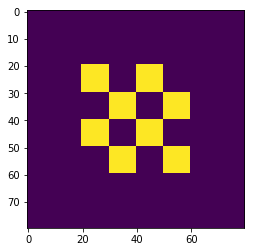

/Users/orecchia/anaconda/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/orecchia/anaconda/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:171: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


Running time of this part is 50.02126908302307 seconds


In [5]:
startTime = time.time()
WhiteFrameWidth = 20
chessNodeWidth = 10
chessElementNumberPerRow = 4
width = (2 * WhiteFrameWidth + chessNodeWidth * chessElementNumberPerRow)
A = makeChessBoard(WhiteFrameWidth, chessNodeWidth, chessElementNumberPerRow)
plt.imshow(A)
plt.show()
sigma = 5
e = 3
graph = fully_connected_e_neighbour_graph(A, sigma, e)
[L, D] = laplacian(graph)
inverse = sparse.linalg.inv(10 * L + sparse.csr_matrix(np.identity(width * width)))
runningTime = (time.time()-startTime)
print('Running time of this part is ' + str(runningTime)  + ' seconds')

In [12]:
n = L.shape[0]

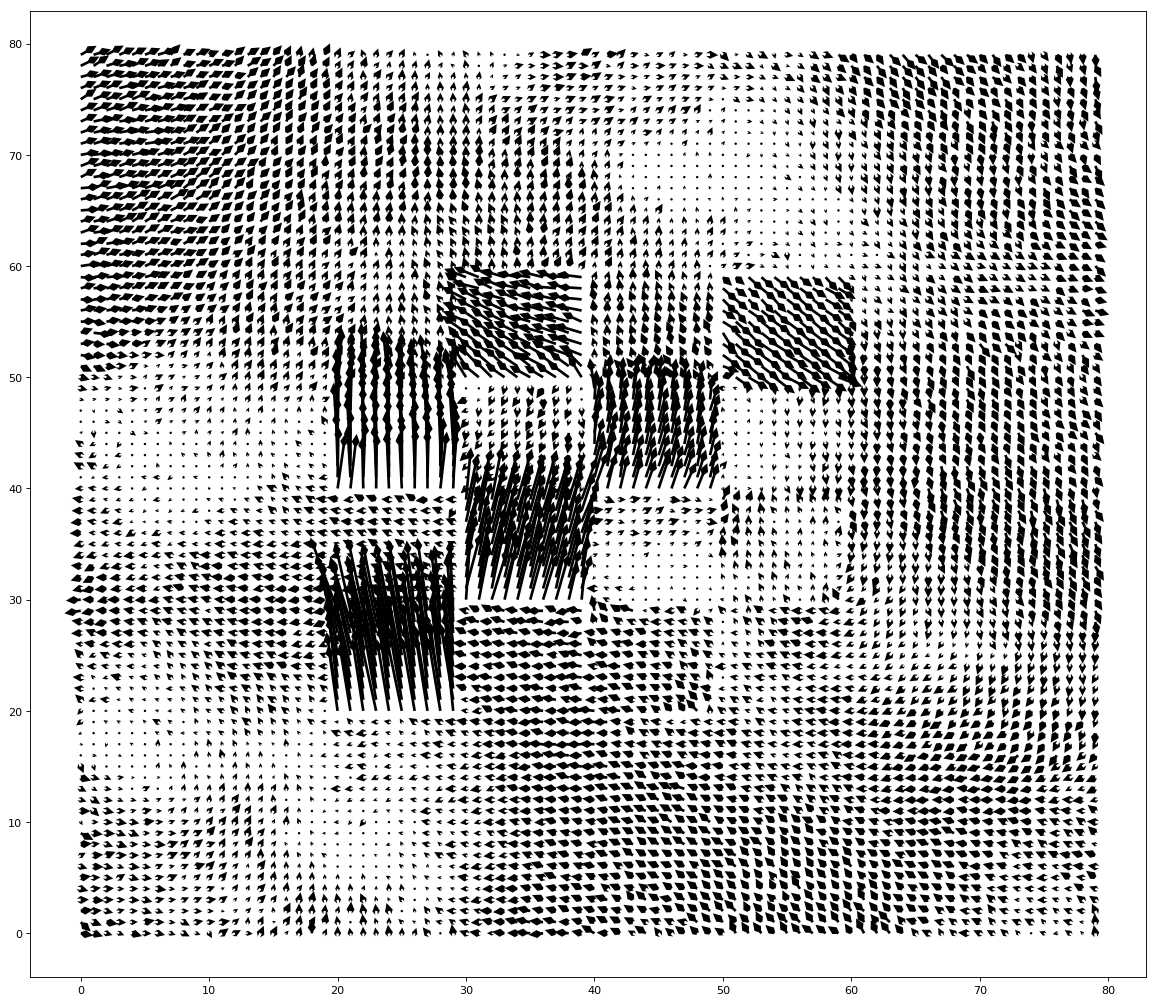

In [43]:
proj = np.random.normal(0,1,(n,2))
field = inverse.dot(proj)
arrows = field.reshape(width, width, 2)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.quiver(arrows[:,:,0],arrows[:,:,1], scale=3, headlength=3)
plt.show()